# **Assignment 6: Emotion Classification**

## **Objective**

To create a model that can identify the emotion (joy, sadness, anger or fear) of a tweet.


## **Data**

The dataset is available at Emotion Classification NLP | Kaggle . Acknowledgment: WASSA-2017 Shared Task on Emotion Intensity. Saif M. Mohammad and Felipe Bravo-Marquez. In Proceedings of the EMNLP 2017 Workshop on Computational Approaches to Subjectivity, Sentiment, and Social Media (WASSA), September 2017, Copenhagen, Denmark. 


## **Problem Statement**

Identifying the emotion behind human text is an important part of NLP for various applications including customer review analysis and artificial intelligence. The owner of Twitter, Elon Musk has fired everyone who understood emotion classification of tweets because they were not "hard core" enough, and now their existing model is no longer working. As a new employee, your job is to develop a model that can classify the emotional connotation behind tweets. Mr. Musk does not disclose why this is needed but laughs eerily whenever asked about it.

# Data

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.preprocessing import LabelEncoder 
import matplotlib.pyplot as plt
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.text import Text
from sklearn.feature_extraction.text import TfidfVectorizer
import string
from nltk.corpus import stopwords
from autocorrect import Speller
import nltk
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout

In [2]:
train = pd.read_csv('emotion-labels-train.csv')
test = pd.read_csv('emotion-labels-test.csv')
valid = pd.read_csv('emotion-labels-val.csv')

In [3]:
train.info

<bound method DataFrame.info of                                                    text    label
0     Just got back from seeing @GaryDelaney in Burs...      joy
1     Oh dear an evening of absolute hilarity I don'...      joy
2     Been waiting all week for this game ❤️❤️❤️ #ch...      joy
3     @gardiner_love : Thank you so much, Gloria! Yo...      joy
4     I feel so blessed to work with the family that...      joy
...                                                 ...      ...
3608  @VivienLloyd Thank you so much! Just home - st...  sadness
3609              Just put the winter duvet on ☃️❄️🌬☔️   sadness
3610  @SilkInSide @TommyJoeRatliff that's so pretty!...  sadness
3611  @BluesfestByron second artist announcement loo...  sadness
3612  I can literally eat creamy pesto pasta topped ...  sadness

[3613 rows x 2 columns]>

In [4]:
train.dtypes

text     object
label    object
dtype: object

In [5]:
#checking null values
train.isna().sum()

text     0
label    0
dtype: int64

In [6]:
#checking duplicate values
train.duplicated().sum()

0

In [7]:
test.info

<bound method DataFrame.info of                                                    text    label
0     You must be knowing #blithe means (adj.)  Happ...      joy
1     Old saying 'A #smile shared is one gained for ...      joy
2     Bridget Jones' Baby was bloody hilarious 😅 #Br...      joy
3     @Elaminova sparkling water makes your life spa...      joy
4     I'm tired of everybody telling me to chill out...      joy
...                                                 ...      ...
3137          Why does Candice constantly pout #GBBO 💄😒  sadness
3138  @redBus_in #unhappy with #redbus CC, when I ta...  sadness
3139  @AceOperative789 no pull him afew weeks ago, s...  sadness
3140  I'm buying art supplies and I'm debating how s...  sadness
3141  @sainsburys Could you ask your Chafford Hundre...  sadness

[3142 rows x 2 columns]>

In [8]:
test.isna().sum()

text     0
label    0
dtype: int64

In [9]:
test.duplicated().sum()

0

In [10]:
valid.info

<bound method DataFrame.info of                                                   text    label
0    @theclobra lol I thought maybe, couldn't decid...      joy
1    Nawaz Sharif is getting more funnier than @kap...      joy
2    Nawaz Sharif is getting more funnier than @kap...      joy
3    @tomderivan73 😁...I'll just people watch and e...      joy
4    I love my family so much #lucky #grateful #sma...      joy
..                                                 ...      ...
342  Common app just randomly logged me out as I wa...  sadness
343  I'd rather laugh with the rarest genius, in be...  sadness
344  If you #invest in my new #film I will stop ask...  sadness
345  Just watched Django Unchained, Other people ma...  sadness
346  @KeithOlbermann depressing how despicable Trum...  sadness

[347 rows x 2 columns]>

In [11]:
valid.isna().sum()

text     0
label    0
dtype: int64

In [12]:
valid.duplicated().sum()

0

No missing values, no duplicates values in three dataset.
Data type of dataset are object, which is correct data type

In [13]:
train_label = train['label']
train_feat = train.drop(columns = ['label']).astype(str)

test_label = test['label']
test_feat = test.drop(columns = ['label']).astype(str)

valid_label = valid['label']
valid_feat = valid.drop(columns = ['label']).astype(str)

In [14]:
train_feat.iloc[6]

text    @Singaholic121 Good morning, love! Happy first...
Name: 6, dtype: object

In [15]:
#encoding label data
encod = LabelEncoder()
train_label_enc = encod.fit_transform(train_label)
train_label_enc = np.array(train_label_enc)
train_label_enc = train_label_enc.reshape(3613, 1)

test_label_enc = encod.fit_transform(test_label)
test_label_enc = np.array(test_label_enc)
test_label_enc = test_label_enc.reshape(3142, 1)

valid_label_enc = encod.fit_transform(valid_label)
valid_label_enc = np.array(valid_label_enc)
valid_label_enc = valid_label_enc.reshape(347, 1)

In [16]:
train_label_enc.shape

(3613, 1)

In [17]:
train_label_enc

array([[2],
       [2],
       [2],
       ...,
       [3],
       [3],
       [3]])

In [18]:
#Printing unique values
valid_dict = valid_label_enc
valid_dict = valid_dict.flatten()
values = dict(zip(valid_dict, valid_label))
print(values)

{2: 'joy', 1: 'fear', 0: 'anger', 3: 'sadness'}


In [19]:
print(train_label_enc.shape)
print(valid_label_enc.shape)
print(test_label_enc.shape)

(3613, 1)
(347, 1)
(3142, 1)


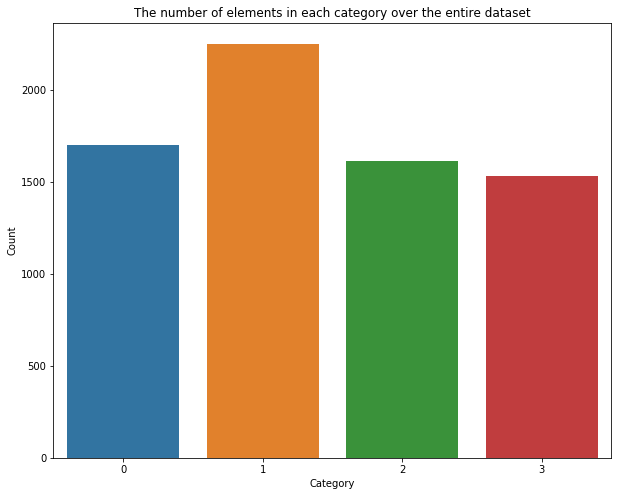

In [20]:
#plotting no of elements in each unique value
plt.figure(figsize = (10, 8))

# concatenating the labels
label = np.concatenate((train_label_enc, valid_label_enc, test_label_enc), axis = 0)

# counting elements in each category
unique, count = np.unique(label, return_counts=True)


sns.barplot(x=unique,y = count )
plt.xlabel('Category')
plt.ylabel("Count")
plt.title('The number of elements in each category over the entire dataset')
plt.show()

In [21]:
data_word = [train_feat, test_feat, valid_feat]
#spel  corrector
spell = Speller()
nltk.download("stopwords")
#stopwords
stop_words = set(stopwords.words('english'))



for tweet in data_word:
    # tokenizing sentence
    tweet['tokenised_sentences'] = tweet['text'].apply(lambda x: sent_tokenize(x) if isinstance(x, str) else [])
    # tokenizing sentence to words
    tweet['tokenised_words'] = tweet['tokenised_sentences'].apply(
        lambda sentences: [word for sent in sentences for word in word_tokenize(sent)] if isinstance(sentences, list) else []
    )
    # spell correction
    tweet['spell_corrected'] = tweet['tokenised_words'].apply(
        lambda tokens: [spell(word) for word in tokens] if isinstance(tokens, list) else []
    )
    # removing stop words
    tweet['stop_word'] = tweet['spell_corrected'].apply(
        lambda tokens: [word for word in tokens if word.lower() not in stop_words] if isinstance(tokens, list) else []
    )
    # words to lowercase
    tweet['lower_cased'] = tweet['stop_word'].apply(
        lambda tokens: [word.lower() for word in tokens] if isinstance(tokens, list) else []
    )

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Manju\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [22]:
#Removing unecesary columns
test_feat = test_feat.drop(columns = ['tokenised_sentences','tokenised_words','spell_corrected','stop_word'])
train_feat = train_feat.drop(columns = ['tokenised_sentences','tokenised_words','spell_corrected','stop_word'])
valid_feat = valid_feat.drop(columns = ['tokenised_sentences','tokenised_words','spell_corrected','stop_word'])

In [23]:
test_feat

,text,lower_cased
0,You must be knowing #blithe means (adj.) Happ...,"[must, knowing, #, elite, means, (, adj, ., ),..."
1,Old saying 'A #smile shared is one gained for ...,"[old, saying, ', #, smile, shared, one, gained..."
2,Bridget Jones' Baby was bloody hilarious 😅 #Br...,"[bridge, jones, ', baby, bloody, hilarious, 😅,..."
3,@Elaminova sparkling water makes your life spa...,"[@, elaminova, sparkling, water, makes, life, ..."
4,I'm tired of everybody telling me to chill out...,"['m, tired, everybody, telling, chill, everyth..."
...,...,...
3137,Why does Candice constantly pout #GBBO 💄😒,"[candle, constantly, #, gb, 💄😒]"
3138,"@redBus_in #unhappy with #redbus CC, when I ta...","[@, radius_in, #, unhappy, #, radius, cc, ,, t..."
3139,"@AceOperative789 no pull him afew weeks ago, s...","[@, aceoperative789, pull, weeks, ago, ,, sadl..."
3140,I'm buying art supplies and I'm debating how s...,"['m, buying, art, supplies, 'm, debating, seri..."


In [24]:
print_five = pd.concat([train_feat.iloc[0:5], train_label.iloc[0:5]], axis=1)
print_five

,text,lower_cased,label
0,Just got back from seeing @GaryDelaney in Burs...,"[got, back, seeing, @, garydelaney, burslem, ....",joy
1,Oh dear an evening of absolute hilarity I don'...,"[oh, dear, evening, absolute, clarity, n't, th...",joy
2,Been waiting all week for this game ❤️❤️❤️ #ch...,"[waiting, week, game, ❤️❤️❤️, #, cheer, #, fri...",joy
3,"@gardiner_love : Thank you so much, Gloria! Yo...","[@, gardener_love, :, thank, much, ,, gloria, ...",joy
4,I feel so blessed to work with the family that...,"[feel, blessed, work, family, nanny, ❤️, nothi...",joy


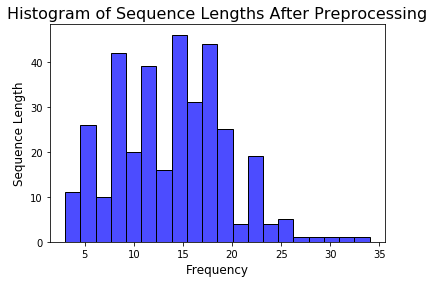

In [51]:
data_word = [train_feat, test_feat, valid_feat]

for data in data_word:
    data['length'] = data['lower_cased'].apply(len)
    
l = data['length']
sns.histplot(l, bins=20, color='blue', edgecolor='black', alpha=0.7)

# Add labels and title
plt.title('Histogram of Sequence Lengths After Preprocessing', fontsize=16)
plt.ylabel('Sequence Length', fontsize=12)
plt.xlabel('Frequency', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()

After training the model and hyperparameter tuning, for max_lenght as 7, we got good accuracy and validation. Most of the sequence in our dataset have this length as we can see our histogram.

## Modelling

In [71]:



# Tokenizer and sequence preparation 
tokenizer = Tokenizer(num_words=200)
tokenizer.fit_on_texts(train_feat['lower_cased'])
sequences = tokenizer.texts_to_sequences(train_feat['lower_cased'])
# Pad sequences 
max_length = 10 
padded_sequences = pad_sequences(sequences, maxlen=max_length)
# Build the model 
model = Sequential([
    Embedding(input_dim=200, output_dim=128, input_length=max_length),
    LSTM(64, return_sequences=True),
    Dropout(0.5),
    LSTM(32),
    Dense(4, activation='softmax') ]) # 4 classes: joy, sadness, anger, fear ])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
# Train the model 
history = model.fit(padded_sequences, train_label_enc, epochs=10, batch_size=32)

Train on 3613 samples
Epoch 1/10
3613/3613 [==============================] - 4s 1ms/sample - loss: 1.3395 - accuracy: 0.3479
Epoch 2/10
3613/3613 [==============================] - 1s 359us/sample - loss: 1.0801 - accuracy: 0.5364
Epoch 3/10
3613/3613 [==============================] - 2s 445us/sample - loss: 0.9016 - accuracy: 0.6092
Epoch 4/10
3613/3613 [==============================] - 2s 525us/sample - loss: 0.8596 - accuracy: 0.6161
Epoch 5/10
3613/3613 [==============================] - 2s 497us/sample - loss: 0.8404 - accuracy: 0.6344
Epoch 6/10
3613/3613 [==============================] - 1s 364us/sample - loss: 0.8214 - accuracy: 0.6413 - loss: 0.8058 - accuracy: 0.64 - ETA: 0s - loss: 0.8128 
Epoch 7/10
3613/3613 [==============================] - 1s 356us/sample - loss: 0.8136 - accuracy: 0.6468
Epoch 8/10
3613/3613 [==============================] - 1s 358us/sample - loss: 0.8018 - accuracy: 0.6454 - loss: 0.8017 - accura
Epoch 9/10
3613/3613 [============================

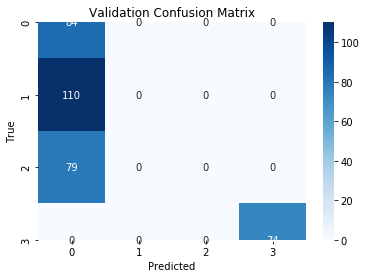

Validation Accuracy: 0.4553314121037464


In [72]:

val_padded = pad_sequences(valid_label_enc, maxlen=max_length)
val_predictions = model.predict(val_padded)
val_labels = valid_label_enc  
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns
# Confusion matrix 
conf_matrix = confusion_matrix(val_labels, val_predictions.argmax(axis=1))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Validation Confusion Matrix')
plt.show()
# Validation accuracy 
val_accuracy = accuracy_score(val_labels, val_predictions.argmax(axis=1))
print("Validation Accuracy:", val_accuracy)

In [73]:
# model 2
# Build the model 

max_length = 42 # changed max length
padded_sequences = pad_sequences(sequences, maxlen=max_length)

model = Sequential([
    Embedding(input_dim=200, output_dim=128, input_length=max_length),
    LSTM(64, return_sequences=True),
    Dropout(0.2), # changed the dropout
    LSTM(32),
    Dense(4, activation='softmax') ]) # 4 classes: joy, sadness, anger, fear ])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
# Train the model 
history = model.fit(padded_sequences, train_label_enc, epochs=10, batch_size=32)

Train on 3613 samples
Epoch 1/10
3613/3613 [==============================] - 7s 2ms/sample - loss: 1.3406 - accuracy: 0.3476
Epoch 2/10
3613/3613 [==============================] - 4s 1ms/sample - loss: 1.0601 - accuracy: 0.5425
Epoch 3/10
3613/3613 [==============================] - 5s 1ms/sample - loss: 0.8891 - accuracy: 0.6045
Epoch 4/10
3613/3613 [==============================] - 4s 1ms/sample - loss: 0.8502 - accuracy: 0.6211
Epoch 5/10
3613/3613 [==============================] - 5s 1ms/sample - loss: 0.8281 - accuracy: 0.6263
Epoch 6/10
3613/3613 [==============================] - 5s 1ms/sample - loss: 0.8075 - accuracy: 0.6410
Epoch 7/10
3613/3613 [==============================] - 5s 1ms/sample - loss: 0.7950 - accuracy: 0.6430
Epoch 8/10
3613/3613 [==============================] - 5s 1ms/sample - loss: 0.7806 - accuracy: 0.6526
Epoch 9/10
3613/3613 [==============================] - 4s 1ms/sample - loss: 0.7704 - accuracy: 0.6579
Epoch 10/10
3613/3613 [===================

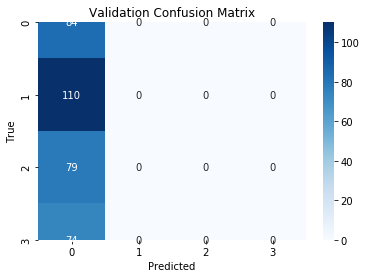

Validation Accuracy: 0.2420749279538905


In [74]:
# confusion matrix for model 2

val_padded = pad_sequences(valid_label_enc, maxlen=max_length)
val_predictions = model.predict(val_padded)
val_labels = valid_label_enc  
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns
# Confusion matrix 
conf_matrix = confusion_matrix(val_labels, val_predictions.argmax(axis=1))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Validation Confusion Matrix')
plt.show()
# Validation accuracy 
val_accuracy = accuracy_score(val_labels, val_predictions.argmax(axis=1))
print("Validation Accuracy:", val_accuracy)

In [77]:
# training model 3
# model 2
# Build the model 

max_length = 7 # changed max length
padded_sequences = pad_sequences(sequences, maxlen=max_length)

model_3 = Sequential([
    Embedding(input_dim=500, output_dim=128, input_length=max_length),
    LSTM(64, return_sequences=True),
    Dropout(0.2), # changed the dropout
    LSTM(32),
    Dense(4, activation='softmax') ]) # 4 classes: joy, sadness, anger, fear ])

model_3.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
# Train the model 
history = model_3.fit(padded_sequences, train_label_enc, epochs=10, batch_size=32)

Train on 3613 samples
Epoch 1/10
3613/3613 [==============================] - 4s 1ms/sample - loss: 1.3133 - accuracy: 0.3604
Epoch 2/10
3613/3613 [==============================] - 1s 273us/sample - loss: 1.0607 - accuracy: 0.5417
Epoch 3/10
3613/3613 [==============================] - 1s 279us/sample - loss: 0.9196 - accuracy: 0.5904 - los
Epoch 4/10
3613/3613 [==============================] - 1s 279us/sample - loss: 0.8729 - accuracy: 0.6125 - loss: 0.8638 - accu
Epoch 5/10
3613/3613 [==============================] - 1s 285us/sample - loss: 0.8562 - accuracy: 0.6219
Epoch 6/10
3613/3613 [==============================] - 1s 290us/sample - loss: 0.8408 - accuracy: 0.6277
Epoch 7/10
3613/3613 [==============================] - 1s 310us/sample - loss: 0.8261 - accuracy: 0.6272
Epoch 8/10
3613/3613 [==============================] - 1s 377us/sample - loss: 0.8161 - accuracy: 0.6333
Epoch 9/10
3613/3613 [==============================] - 2s 514us/sample - loss: 0.8035 - accuracy: 0.647

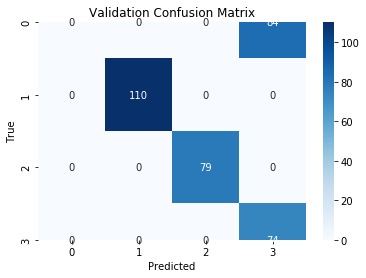

Validation Accuracy: 0.7579250720461095


In [78]:
# confusion matrix for model 3

val_padded = pad_sequences(valid_label_enc, maxlen=max_length)
val_predictions = model_3.predict(val_padded)
val_labels = valid_label_enc  

from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns

# Confusion matrix 
conf_matrix = confusion_matrix(val_labels, val_predictions.argmax(axis=1))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Validation Confusion Matrix')
plt.show()
# Validation accuracy 
val_accuracy = accuracy_score(val_labels, val_predictions.argmax(axis=1))
print("Validation Accuracy:", val_accuracy)